In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
emissions = pd.read_csv("../data/original/extensions_1750-2500.csv")

In [3]:
volcanic = pd.read_csv("../data/original/volcanic_solar.csv")

In [4]:
baseline_scenario = "low"
volcanic_subset = volcanic[volcanic["Scenario"].isin([baseline_scenario])].reset_index(
    drop=True
)
emissions_subset = emissions[
    emissions["scenario"].isin([baseline_scenario])
].reset_index(drop=True)

In [5]:
volcanic_subset.iloc[:, 269:] = 0

In [6]:
def copy_baseline(scenario_name: str, emissions_baseline, volcanic_baseline):
    emissions_new_scenario = emissions_baseline.copy().reset_index(drop=True)
    emissions_new_scenario["scenario"] = scenario_name

    volcanic_new_scenario = volcanic_baseline.copy().reset_index(drop=True)
    volcanic_new_scenario["Scenario"] = scenario_name

    return emissions_new_scenario, volcanic_new_scenario

In [7]:
def calculate_drawdown_from_CDR(CDR_deployment, trace):
    drawdown_full = np.convolve(CDR_deployment, trace, mode="full")
    drawdown_tseries = drawdown_full[: len(CDR_deployment)]
    return drawdown_tseries

In [8]:
def calculate_drawdown_with_embedded_emissions(CDR_deployment, 
                             plant_lifetime: int = 20):
    
    df_CDR_plants = pd.DataFrame(data=CDR_deployment, columns=["CDR_deployment"])
    df_CDR_plants["year"]=years
    for plant_age in np.arange(0,plant_lifetime):
        df_CDR_plants[plant_age]=0.0

    for i, year in enumerate(df_CDR_plants.year[1:]):
        df_lastyear = df_CDR_plants[df_CDR_plants['year']==(year-1)]
        
        df_CDR_plants.loc[df_CDR_plants['year']==year,
            (np.arange(1,plant_lifetime)).tolist()] = df_lastyear[list(range(0,plant_lifetime-1))].values
        
        capacity_from_last_year = np.nansum(df_CDR_plants.loc[df_CDR_plants['year']==year,
            (np.arange(1,plant_lifetime)).tolist()])
        
        capacity_needed = df_CDR_plants.loc[df_CDR_plants['year']==year,'CDR_deployment'].values[0]
        
        new_capacity_installed = capacity_needed - capacity_from_last_year
        
        df_CDR_plants.loc[df_CDR_plants['year']==year,
            0] = new_capacity_installed

    CDR_first_year = df_CDR_plants[0]
    CDR_subsequent_years = df_CDR_plants[np.arange(1,plant_lifetime).tolist()].sum(axis=1)
    
    actual_emissions = (CDR_first_year*1.85)+(CDR_subsequent_years*-1.15)

    return actual_emissions

In [9]:
emissions_instant, volcanic_instant = copy_baseline(
    scenario_name="instant-removal",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_instant_offset, volcanic_instant_offset = copy_baseline(
    scenario_name="instant-removal-offsetting",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_delay, volcanic_delay = copy_baseline(
    scenario_name="physical-delay",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_delay_offset, volcanic_delay_offset = copy_baseline(
    scenario_name="physical-delay-offsetting",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_accelerated, volcanic_accelerated = copy_baseline(
    scenario_name="accelerated-emissions",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_accelerated_offset, volcanic_accelerated_offset = copy_baseline(
    scenario_name="accelerated-emissions-offsetting",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_upfront, volcanic_upfront = copy_baseline(
    scenario_name="upfront-embodied",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

emissions_upfront_offset, volcanic_upfront_offset = copy_baseline(
    scenario_name="upfront-embodied-offsetting",
    emissions_baseline=emissions_subset,
    volcanic_baseline=volcanic_subset,
)

# Calculate and write new emissions

In [10]:
# From AR6 IAMs
AR6_cdr = pd.read_csv("../data/CDR_1.5deg_Fuhrman.csv")["Val"]
row_num = emissions_subset.index[emissions_delay["variable"] == "CO2 FFI"][0]
years = emissions_subset.iloc[row_num, 4:].index.values.astype("float32")
CDR_deployment = np.zeros(np.shape(years))
CDR_deployment[255:351] = -AR6_cdr
CDR_deployment[351:] = -AR6_cdr.values[-1]

In [11]:
trace_physical_delay = -np.ones(20) / 19
trace_physical_delay[0] = 0
trace_instant_removal = np.zeros(20)
trace_instant_removal[0] = -1
trace_accelerated_emissions = -np.ones(20) / 10
trace_accelerated_emissions[0] = 0.9
print(np.nansum(trace_physical_delay))
print(np.nansum(trace_instant_removal))
print(np.nansum(trace_accelerated_emissions))

drawdown_physical_delay = calculate_drawdown_from_CDR(
    CDR_deployment=CDR_deployment, trace=trace_physical_delay
)
drawdown_instant_removal = calculate_drawdown_from_CDR(
    CDR_deployment=CDR_deployment, trace=trace_instant_removal
)
drawdown_accelerated_emissions = calculate_drawdown_from_CDR(
    CDR_deployment=CDR_deployment, trace=trace_accelerated_emissions
)

drawdown_embodied_emissions = calculate_drawdown_with_embedded_emissions(CDR_deployment=CDR_deployment).values

-0.9999999999999998
-1.0
-0.9999999999999999


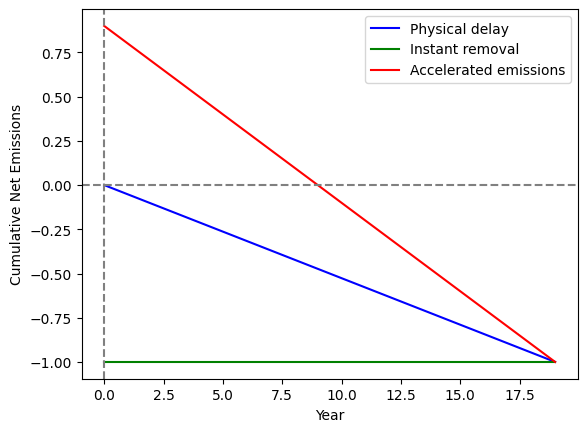

In [12]:
plt.plot(np.cumsum(trace_physical_delay), label="Physical delay", color="blue")
plt.plot(np.cumsum(trace_instant_removal), label="Instant removal", color="green")
plt.plot(
    np.cumsum(trace_accelerated_emissions), label="Accelerated emissions", color="red"
)
plt.legend()
plt.axhline(y=0, linestyle="--", color="gray")
plt.xlabel("Year")
plt.ylabel("Cumulative Net Emissions")
plt.axvline(x=0, linestyle="--", color="gray")
plt.savefig("../figures/Trace_buying_1ton_CDR.png")

In [13]:
drawdown_physical_delay_offset = drawdown_physical_delay + CDR_deployment
drawdown_instant_removal_offset = drawdown_instant_removal + CDR_deployment
drawdown_accelerated_emissions_offset = drawdown_accelerated_emissions + CDR_deployment
drawdown_embodied_emissions_offset = drawdown_embodied_emissions + CDR_deployment

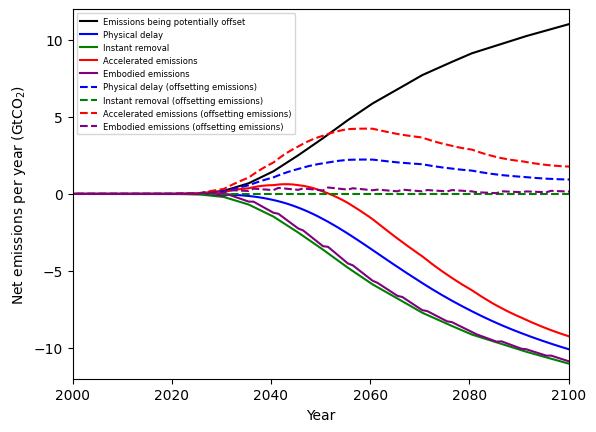

In [19]:
plt.plot(
    years,
    CDR_deployment,
    "-",
    label="Emissions being potentially offset",
    color="black",
)
plt.xlim([2000, 2100])
plt.plot(years, drawdown_physical_delay, label="Physical delay", color="blue")
plt.plot(years, drawdown_instant_removal, label="Instant removal", color="green")
plt.plot(
    years, drawdown_accelerated_emissions, label="Accelerated emissions", color="red"
)
plt.plot(years, drawdown_embodied_emissions, label="Embodied emissions", color="purple")

plt.plot(
    years,
    drawdown_physical_delay_offset,
    "--",
    label="Physical delay (offsetting emissions)",
    color="blue",
)
plt.plot(
    years,
    drawdown_instant_removal_offset,
    "--",
    label="Instant removal (offsetting emissions)",
    color="green",
)
plt.plot(
    years,
    drawdown_accelerated_emissions_offset,
    "--",
    label="Accelerated emissions (offsetting emissions)",
    color="red",
)
plt.plot(
    years,
    drawdown_embodied_emissions_offset,
    "--",
    label="Embodied emissions (offsetting emissions)",
    color="purple",
)
plt.legend(fontsize=6, ncols=1)
plt.ylabel("Net emissions per year (GtCO$_2$)")
plt.xlabel("Year")
plt.ylim([-12, 12])
plt.savefig("../figures/Net_emissions_per_year.png")

# Write new emissions

In [18]:
row_num = emissions_delay.index[emissions_delay["variable"] == "CO2 FFI"][0]
emissions_delay.iloc[row_num, 4:] = (
    emissions_delay.iloc[row_num, 4:] + drawdown_physical_delay
)

row_num = emissions_delay_offset.index[emissions_delay_offset["variable"] == "CO2 FFI"][
    0
]
emissions_delay_offset.iloc[row_num, 4:] = (
    emissions_delay_offset.iloc[row_num, 4:] + drawdown_physical_delay_offset
)

row_num = emissions_instant.index[emissions_instant["variable"] == "CO2 FFI"][0]
emissions_instant.iloc[row_num, 4:] = (
    emissions_instant.iloc[row_num, 4:] + drawdown_instant_removal
)

row_num = emissions_instant_offset.index[
    emissions_instant_offset["variable"] == "CO2 FFI"
][0]
emissions_instant_offset.iloc[row_num, 4:] = (
    emissions_instant_offset.iloc[row_num, 4:] + drawdown_instant_removal_offset
)

row_num = emissions_accelerated.index[emissions_accelerated["variable"] == "CO2 FFI"][0]
emissions_accelerated.iloc[row_num, 4:] = (
    emissions_accelerated.iloc[row_num, 4:] + drawdown_accelerated_emissions
)

row_num = emissions_accelerated_offset.index[
    emissions_accelerated_offset["variable"] == "CO2 FFI"
][0]
emissions_accelerated_offset.iloc[row_num, 4:] = (
    emissions_accelerated_offset.iloc[row_num, 4:]
    + drawdown_accelerated_emissions_offset
)

row_num = emissions_upfront.index[emissions_upfront["variable"] == "CO2 FFI"][0]
emissions_upfront.iloc[row_num, 4:] = (
    emissions_upfront.iloc[row_num, 4:] + drawdown_embodied_emissions
)

row_num = emissions_upfront_offset.index[
    emissions_upfront_offset["variable"] == "CO2 FFI"
][0]
emissions_upfront_offset.iloc[row_num, 4:] = (
    emissions_upfront_offset.iloc[row_num, 4:] + drawdown_embodied_emissions_offset
)

# Save new emissions

In [19]:
emissions_subset['scenario']="baseline"
volcanic_subset['Scenario']="baseline"

In [20]:
emissions_combined = pd.concat(
    [
        emissions_subset,
        emissions_delay,
        emissions_delay_offset,
        emissions_instant,
        emissions_instant_offset,
        emissions_accelerated,
        emissions_accelerated_offset,
        emissions_upfront,
        emissions_upfront_offset,
    ],
    ignore_index=True,
)

In [21]:
emissions_combined.to_csv("../data/modified/emissions_low.csv", index=False)

In [22]:
volcanic_combined = pd.concat(
    [
        volcanic_subset,
        volcanic_delay,
        volcanic_delay_offset,
        volcanic_instant,
        volcanic_instant_offset,
        volcanic_accelerated,
        volcanic_accelerated_offset,
        volcanic_upfront,
        volcanic_upfront_offset,
    ],
    ignore_index=True,
)
volcanic_combined.to_csv("../data/modified/volcanic.csv", index=False)